<a href="https://colab.research.google.com/github/Otm02/GreenFilter-AI/blob/main/GreenFilter_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading

In [ ]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
from langdetect import detect, LangDetectException
import openai


In [ ]:
# mount drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/AI EarthHack 2024/"

# Data Cleaning

In [ ]:
# Load the provided CSV file (ours was edited using GPT 4 to add an isRelevant column based on its relevance to sustainability)
df = pd.read_csv('Updated_EarthHack_Dataset.csv', encoding='ISO-8859-1')

In [ ]:
key = input("Enter your API key for the OpenAI GPT-3.5 API: ")

# Initialize the OpenAI API client
client = OpenAI(api_key=key)

#Function to determine if the problem and solution are relevant to environmental sustainability. It returns 1 if relevant, otherwise 0.
def is_relevant_to_environmental_sustainability(problem, solution):
    prompt = f"Problem: {problem}\nSolution: {solution}\nIs this problem and solution relevant to environmental sustainability? Answer 1 for Yes and 0 for No."

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
              {"role": "user", "content": prompt}
            ]
        )
        answer = response.choices[0].message
        return 1 if answer == "1" else 0
    except Exception as e:
        print(f"Error in processing: {e}")
        return 0

# Add the column 'isRelevant' to the DataFrame
df['isRelevant'] = df.apply(lambda row: is_relevant_to_environmental_sustainability(row['problem'], row['solution']), axis=1)

In [ ]:
# Function to remove odd characters and keep only ASCII
def remove_odd_characters(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

# Function to detect the language of the text using langdetect
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Function to count the number of words
def word_count(text):
    return len(text.split())

# Remove odd characters from problems and solutions
df['problem'] = df['problem'].apply(lambda x: remove_odd_characters(str(x)))
df['solution'] = df['solution'].apply(lambda x: remove_odd_characters(str(x)))

# Convert text to lowercase for standardization
df['problem'] = df['problem'].str.lower()
df['solution'] = df['solution'].str.lower()

# Filter out non-English entries and entries that are too short or too long
df = df[(df['problem'].apply(detect_language) == 'en') &
        (df['problem'].apply(word_count).between(5, 200)) &
        (df['solution'].apply(word_count).between(5, 200))]

# Drop rows with missing values in problem or solution
df.dropna(subset=['problem', 'solution'], inplace=True)

# Save the cleaned dataset
df.to_csv('Cleaned_EarthHack_Dataset.csv', index=False)

# Modelling

In [ ]:
dfTrain = pd.read_csv('Cleaned_EarthHack_Dataset.csv')

In [ ]:
#Classifies the entries based on if they are relevant or not.
class_counts = dfTrain['isRelevant'].value_counts()
print(class_counts)

1    737
0    129
Name: isRelevant, dtype: int64


In [ ]:

min_class_count = class_counts.min()

# This is to clearly separate the two classes. This will be used for preprocessing.
df_class_0 = dfTrain[dfTrain['isRelevant'] == 0]
df_class_1 = dfTrain[dfTrain['isRelevant'] == 1]

# Sample from the majority class
df_class_0_under = df_class_0.sample(min_class_count)
df_class_1_under = df_class_1.sample(min_class_count)

#Now that we separated and balanced the entries (to avoid training it only for positive ideas, which can lead to it not detecting patterns)
df_train_balanced = pd.concat([df_class_0_under, df_class_1_under], axis=0)

# Shuffle the dataset
df_train_balanced = df_train_balanced.sample(frac=1).reset_index(drop=True)

dfTrain = df_train_balanced


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#We're using tokenizer to generate numerical entries based on how common certain keywords are.
tokenizer = Tokenizer()
dfTrain['problem'] = dfTrain['problem'].astype('str')
dfTrain['solution'] = dfTrain['solution'].astype('str')
tokenizer.fit_on_texts(dfTrain['problem'] + ' ' + dfTrain['solution'])


#The model requires a sequence.
sequences = tokenizer.texts_to_sequences(dfTrain['problem'] + ' ' + dfTrain['solution'])

#adjust this as needed, depending on the training data set.
max_sequence_length = 206
X = pad_sequences(sequences, maxlen=max_sequence_length)


In [ ]:
from tensorflow.keras.utils import to_categorical

#Simply categorizes the entries on whether or not they are relevant or not, in a way that is good for tensorflow functions.
y = to_categorical(dfTrain['isRelevant'])

In [ ]:
from sklearn.model_selection import train_test_split
#Splits it for training and testing. Validation is done later.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape) #This is just to know the dimension. "max_sequence_length" should be equal to the number that is displayed down here.

(206, 206)


In [ ]:
#Prepping up the variables to be used in the parameters.
sequence_length = X_train.shape[0]
input_dim =  1
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 100

print("sequence_length: {}\ninput_dim: {}".format(sequence_length, input_dim))
#Adding the appropriate layers. LSTM is the recurrent part of our NN that we're gonna use to avoid the vanishing gradient problem.
#Dropout introduces randomness to avoid overfitting (especially important with out small set of data...)
#Dense is simply just several sub layers of neurons that all link to each other with their respective weights, all using the sigmoid activation, as we're addressing something binary.
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_sequence_length))
model.add(Bidirectional(LSTM(64,return_sequences = True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(units = 2, activation = 'sigmoid'))



sequence_length: 206
input_dim: 1


In [ ]:
#Sets the relevant parameters. This is generally what works for us.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.learning_rate = 0.00001
model.beta_1 = 0.9
model.beta_2 = 0.999
model.amsgrad = False

In [ ]:
import numpy as np
#This is because it expects a (N, N, 1) format.
X_train = np.expand_dims(X_train, axis=-1)

In [ ]:
print(model.summary()) #To ensure that the layers are formed, also to know what output shapes it wants for debugging.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 206, 100)          452000    
                                                                 
 bidirectional (Bidirection  (None, 206, 128)          84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 206, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 1

In [ ]:

print(X_train.shape)

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1) #The actual training for 20 epochs.

(206, 206, 1)
Epoch 1/20
6/6 [==============================] - 13s 474ms/step - loss: 0.6899 - accuracy: 0.5514 - val_loss: 0.6835 - val_accuracy: 0.5238
Epoch 2/20
6/6 [==============================] - 1s 211ms/step - loss: 0.6717 - accuracy: 0.6378 - val_loss: 0.6714 - val_accuracy: 0.5714
Epoch 3/20
6/6 [==============================] - 1s 173ms/step - loss: 0.6233 - accuracy: 0.6919 - val_loss: 0.5884 - val_accuracy: 0.8095
Epoch 4/20
6/6 [==============================] - 1s 206ms/step - loss: 0.4475 - accuracy: 0.8432 - val_loss: 0.3257 - val_accuracy: 0.8571
Epoch 5/20
6/6 [==============================] - 1s 208ms/step - loss: 0.2683 - accuracy: 0.9135 - val_loss: 0.4191 - val_accuracy: 0.8571
Epoch 6/20
6/6 [==============================] - 1s 209ms/step - loss: 0.1429 - accuracy: 0.9838 - val_loss: 0.2814 - val_accuracy: 0.8571
Epoch 7/20
6/6 [==============================] - 2s 254ms/step - loss: 0.0661 - accuracy: 0.9946 - val_loss: 0.3588 - val_accuracy: 0.8571
Epoch

In [ ]:
#Ensuring that our testing data is formatted properly for evaluation.
X_test_reshaped = X_test.reshape((X_test.shape[0], sequence_length, input_dim))
evaluation = model.evaluate(X_test_reshaped, y_test)



print(f"Test Accuracy: {evaluation[1]*100:.2f}%")

2/2 [==============================] - 0s 27ms/step - loss: 0.6153 - accuracy: 0.8654
Test Accuracy: 86.54%


In [ ]:
#This is just so that we can visually see a heatmap for the subsequent block for the training data.
predicted_classes1 = np.argmax(model.predict(X_test), axis = -1)
y_true = np.argmax(y_test, axis = -1)

2/2 [==============================] - 2s 16ms/step


<Axes: >

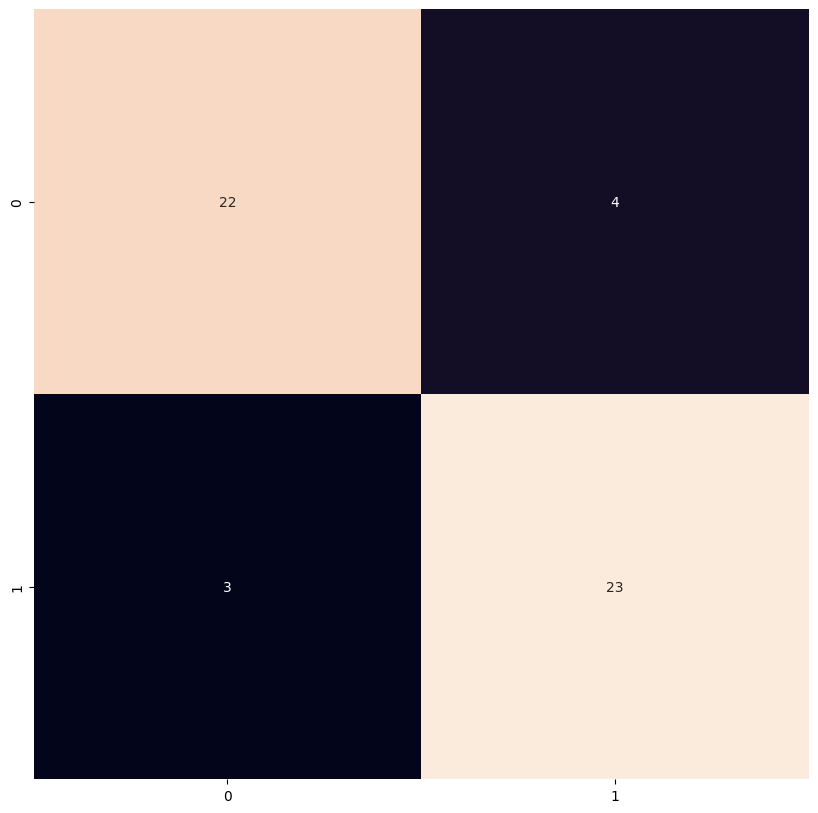

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true, predicted_classes1)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, cbar = False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes1))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        26
           1       0.85      0.88      0.87        26

    accuracy                           0.87        52
   macro avg       0.87      0.87      0.87        52
weighted avg       0.87      0.87      0.87        52



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def preprocess_and_predict(model, tokenizer, problem_text, solution_text, max_sequence_length):

    input_text = np.array([problem_text + ' ' + solution_text])

    input_text = input_text.astype('str')  # Ensure text is in string format
    sequences = tokenizer.texts_to_sequences(input_text)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)


    predictions = model.predict(padded_sequences)

    predicted_class = np.argmax(predictions)

    if predicted_class == 1:
      print("The proposed problem and solution are relevant.")
    else:
      print("The proposed problem and solution are not relevant.")






In [ ]:
problem = input("Propose a problem:")
solution = input("Propose a solution:")

preprocess_and_predict(model, tokenizer, problem, solution, 206)

Propose a problem:Largely considered the most urgent and impactful contemporary environmental crises by scientists and other experts, climate change is the most high-profile challenge facing the world today.
Propose a solution:The single-most important thing that we can do to combat climate change is to drastically reduce our consumption of fossil fuels. The burning of coal, oil, and natural gas in our buildings, industrial processes, and transportation is responsible for the vast majority of emissions that are warming the planet—more than 75 percent. In addition to altering the climate, dirty energy also comes with unacceptable ecological and human health impacts. We must replace coal, oil, and gas with renewable and efficient energy sources.
1/1 [==============================] - 0s 25ms/step
The proposed problem and solution are relevant.


In [ ]:


with open('tokenizerGreenFilter.pickle', 'wb') as filter:
    pickle.dump(tokenizer, filter, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model_json = model.to_json()
with open("GreenFilterModel.json", "w") as json_file:
  json_file.write(model_json)

# WebUI

In [ ]:
#This is pretty much identical to the one defined in Modelling, just so that for anyone that wants to run this and doesn't want to go through the hassle in the Modelling section in order to do so.
def WebUIPredict(model, tokenizer, problem_text, solution_text):

    input_text = np.array([problem_text + ' ' + solution_text])

    input_text = input_text.astype('str')  # Ensure text is in string format
    sequences = tokenizer.texts_to_sequences(input_text)
    padded_sequences = pad_sequences(sequences, maxlen=206)


    predictions = model.predict(padded_sequences)

    predicted_class = np.argmax(predictions)
    print(sequences)

    if predicted_class == 1:
      return True
    else:
      return False






In [ ]:
tk = Tokenizer()
with open('tokenizerGreenFilter.pickle', 'rb') as handle:
    tk = pickle.load(handle)

In [ ]:
with open('GreenFilterModel.json', 'r') as json_file:
  savedModel = json_file.read()

In [ ]:
modelWB = tf.keras.models.model_from_json(savedModel)

In [ ]:
problemW = input("Propose a problem:")
solutionW = input("Propose a solution:")

WebUIPredict(modelWB, tk, problemW, solutionW)

Propose a problem:Pollution is a well known issue, caused by the overabundance of greenhouse gas emitted by factories and vehicles.
Propose a solution:A solution to this would be to go to the factories and force them to not dispose as many products through combustion. Furthermore, we can replace petroleum-based vehicles with electric vehicles.
1/1 [==============================] - 0s 29ms/step
[[92, 10, 5, 387, 1418, 185, 891, 17, 1, 4, 276, 199, 17, 2, 331, 5, 20, 3, 8, 41, 12, 3, 556, 3, 1, 2, 2898, 63, 3, 27, 386, 15, 134, 25, 90, 270, 61, 11, 674, 2313, 100, 331, 13, 474, 331]]
The proposed problem and solution are not relevant.


In [ ]:
%mkdir templates
%cd templates
!git clone -b ui https://github.com/Otm02/GreenFilter-AI .

/content/templates
Cloning into '.'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 39 (delta 14), reused 24 (delta 7), pack-reused 0
Receiving objects: 100% (39/39), 1.62 MiB | 7.05 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://5bdc5u5jsdn-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [ ]:
# Create a Flask app
from flask import Flask, render_template, jsonify, request
from google.colab.output import eval_js

app = Flask(__name__, template_folder='.')

# Define a route to render the HTML page
@app.route('/')
def index():
    return render_template('bot.html')

# Run the Flask app
@app.route('/solve', methods=['POST'])
def get_response():
    problem = request.form.get('problem')
    print(problem)
    solution = request.form.get('solution')
    print(solution)

    # Check if both parameters are provided
    if problem is None or solution is None:
        return jsonify({'error': 'Both "problem" and "solution" parameters are required'}), 400

    # Process the parameters and generate a response
    answer = "test" #WebUIPredict(modelWB, tk, problem, solution)

    # Return the response as JSON
    return jsonify({'answer': answer})

    return jsonify(data)
if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:45:18] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:45:18] "GET /static/main.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:45:18] "GET /static/main.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:45:19] "GET /static/img/bot.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:45:19] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:45:21] "POST /solve HTTP/1.1" 400 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:45:21] "GET /static/img/guy.jpg HTTP/1.1" 200 -


None
None


INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:52:40] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:52:40] "GET /static/main.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:52:40] "GET /static/main.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:52:41] "GET /static/img/bot.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:52:41] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:52:43] "POST /solve HTTP/1.1" 400 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:52:43] "GET /static/img/guy.jpg HTTP/1.1" 200 -


None
None


INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:54:32] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:54:32] "GET /static/main.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:54:32] "GET /static/main.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:54:33] "GET /static/img/bot.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:54:33] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:54:37] "GET /static/img/guy.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:54:37] "POST /solve HTTP/1.1" 400 -


None
None


INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:55:19] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:55:19] "GET /static/main.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:55:19] "GET /static/main.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:55:20] "GET /static/img/bot.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:55:20] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:57:51] "GET /static/img/guy.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Jan/2024 01:57:51] "POST /solve HTTP/1.1" 400 -


None
None
